## DBSCAN
Noise seven çılgın algoritma! 

# sample 1 :

### Müşterilerin alışveriş davranışlarına göre gruplanması ve aykırı verilerin keşfi

#### order_details, customers, orders

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
from sqlalchemy import create_engine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

In [9]:
user='postgres'
password = "123456"
host = "localhost"
port = 5432
database = "Gyk1Nortwind"

In [10]:
engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}')

In [13]:
query = """ 
SELECT 
    c.customer_id,
    COUNT(DISTINCT o.order_id) AS total_orders,
    SUM(od.unit_price * od.quantity * (1 - od.discount)) AS total_spent,
    AVG(order_total.order_value) AS avg_order_value
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
JOIN order_details od ON o.order_id = od.order_id
JOIN (
    SELECT 
        order_id, 
        SUM(unit_price * quantity * (1 - discount)) AS order_value
    FROM order_details
    GROUP BY order_id
) AS order_total ON order_total.order_id = o.order_id
GROUP BY c.customer_id
HAVING COUNT(o.order_id) > 0
ORDER BY total_spent DESC;

"""

In [14]:
df = pd.read_sql_query(query, engine)

In [15]:
print(df.head)

<bound method NDFrame.head of    customer_id  total_orders    total_spent  avg_order_value
0        QUICK            28  110277.305030      4579.313957
1        ERNSH            30  104874.978144      3908.101191
2        SAVEA            31  104361.949540      3716.777438
3        RATTC            18   51097.800828      2444.851739
4        HUNGO            19   49979.905081      2476.719096
..         ...           ...            ...              ...
84       GALED             5     836.699995       181.049999
85       NORTS             3     649.000000       267.500000
86       LAUGB             3     522.499992       188.749997
87       LAZYK             2     356.999998       178.499999
88       CENTC             1     100.799999       100.799999

[89 rows x 4 columns]>


In [16]:
X = df[["total_orders", "total_spent", "avg_order_value"]]

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [30]:
def find_optimal_eps(X_scaled, min_samples=3):
    neighbors = NearestNeighbors(n_neighbors=min_samples).fit(X_scaled)
    distances,_ = neighbors.kneighbors(X_scaled)

    distances = np.sort(distances[:, min_samples-1])

    kneedle = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')
    optimal_eps = distances[kneedle.elbow]

    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.axvline(x=kneedle.elbow, color='r', linestyle='--', label=f'Optimal eps: {optimal_eps:.2f}')
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'{min_samples}-th nearest neighbor distance')
    plt.title('Elbow Method for Optimal eps')
    plt.legend()
    plt.grid(True)
    plt.show()

    return optimal_eps

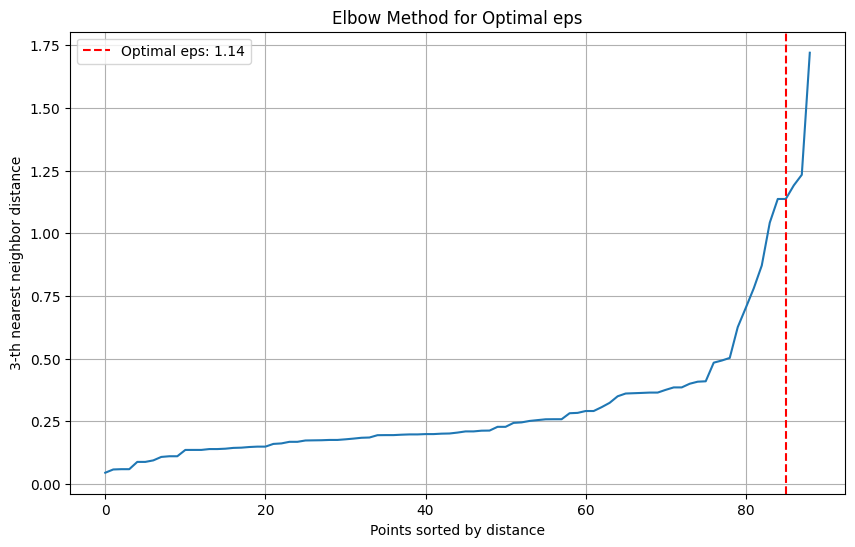

In [31]:
optimal_eps = find_optimal_eps(X_scaled)

In [32]:
dbscan = DBSCAN(eps=optimal_eps, min_samples=3)

In [33]:
dbscan.fit_predict(X_scaled)

array([ 0,  0,  0, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1])

In [34]:
df['cluster'] = dbscan.fit_predict(X_scaled)

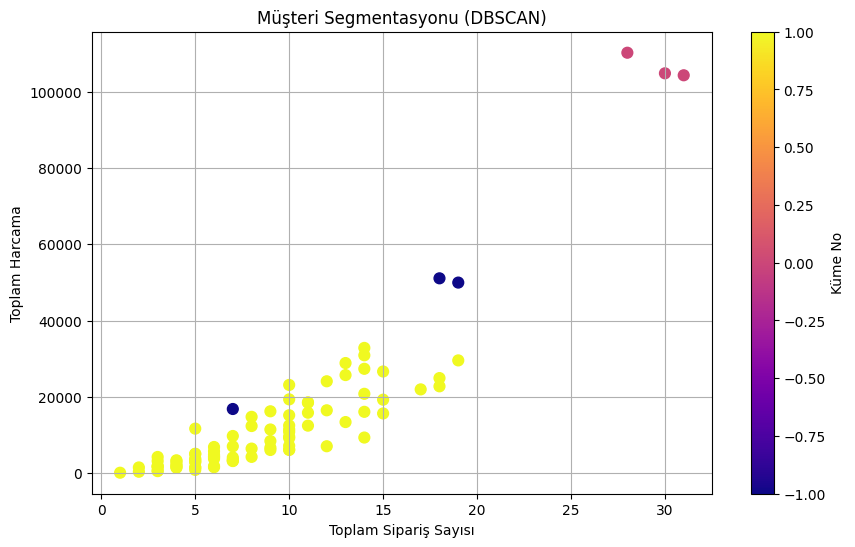

In [35]:
plt.figure(figsize=(10, 6))
plt.scatter(df['total_orders'], df['total_spent'], c=df['cluster'], cmap='plasma', s=60)
plt.xlabel("Toplam Sipariş Sayısı")
plt.ylabel("Toplam Harcama")
plt.title("Müşteri Segmentasyonu (DBSCAN)")
plt.grid(True)
plt.colorbar(label='Küme No')
plt.show()

In [36]:
## AYKIRI değerlerin bulunması için : 

outliers = df[df["cluster"]==1]
print("Aykırı veri sayısı: ", len(outliers))
print(outliers[["customer_id", "total_orders", "total_spent"]])

Aykırı veri sayısı:  83
   customer_id  total_orders   total_spent
5        HANAR            14  32841.369948
6        KOENE            14  30908.383873
7        FOLKO            19  29567.562490
8        MEREP            13  28872.190156
9        WHITC            14  27363.604900
..         ...           ...           ...
84       GALED             5    836.699995
85       NORTS             3    649.000000
86       LAUGB             3    522.499992
87       LAZYK             2    356.999998
88       CENTC             1    100.799999

[83 rows x 3 columns]


HW : 

>> **Problem 2: Ürün Kümeleme (Benzer Ürünler) Veritabanı tabloları: Products, OrderDetails**

>> Soru: “Benzer sipariş geçmişine sahip ürünleri DBSCAN ile gruplandırın. Az satılan ya da alışılmadık kombinasyonlarda geçen ürünleri belirleyin.”

Özellik vektörleri:

- Ortalama satış fiyatı
- Satış sıklığı
- Sipariş başına ortalama miktar
- Kaç farklı müşteriye satıldı

->> || Amaç: Benzer ürünlerin segmentasyonu

-1 olan ürünler → belki özel ürünler veya niş ihtiyaçlar

>> **Problem 3: Tedarikçi Segmentasyonu Veritabanı tabloları: Suppliers, Products, OrderDetails**

>> Soru: “Tedarikçileri sağladıkları ürünlerin satış performansına göre gruplandırın. Az katkı sağlayan veya sıra dışı tedarikçileri bulun.”

Özellik vektörleri:

- Tedarik ettiği ürün sayısı
- Bu ürünlerin toplam satış miktarı
- Ortalama satış fiyatı
- Ortalama müşteri sayısı

>> **Problem 4: Ülkelere Göre Satış Deseni Analizi Veritabanı tabloları: Customers, Orders, OrderDetails**

>> Soru: “Farklı ülkelerden gelen siparişleri DBSCAN ile kümeleyin. Sıra dışı sipariş alışkanlığı olan ülkeleri tespit edin.”

Özellikler:

- Toplam sipariş
- Ortalama sipariş tutarı
- Sipariş başına ürün sayısı

****Api ile sunum yapınız ****Min_samples optimizasyonu : ARGE